<a href="https://colab.research.google.com/github/anuragal/deep-learning/blob/master/S6_Final/assignment6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [28]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The overrides

Override Batchnorm to create ghostbatchnorm

In [0]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias


class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.dropout_value = 0.1
        self.ghostbatchnorm = False
        self.num_splits = 1

        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            self.batchnorm(16),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        ) # In: 28x28x1 | Out: 26x26x8 | RF: 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            self.batchnorm(12),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        ) # In: 26x26x8 | Out: 24x24x10 | RF: 5

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
        ) # In: 24x24x10 | Out: 22x22x12 | RF: 7

         # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # In: 22x22x12 | Out: 11x11x12 | RF: 8

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            self.batchnorm(16),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        ) # In: 11x11x12 | Out: 9x9x16 | RF: 12

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            self.batchnorm(16),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        ) # In: 9x9x16 | Out: 7x7x16 | RF: 16
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            self.batchnorm(16),
            nn.ReLU(),
        ) # In: 7x7x16 | Out: 5x5x16 | RF: 20

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=1)
        ) # In: 5x5x16 | Out: 1x1x16 | RF: 28
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # In: 1x1x16 | Out: 1x1x10 | RF: 28


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

    def set_ghostbatchnorm(self, is_ghostbatchnorm = False, splits = 1):
        self.ghostbatchnorm = is_ghostbatchnorm
        self.num_splits = splits

    def batchnorm(self, num_features):
        if self.ghostbatchnorm and self.ghostbatchnorm == True:
            return GhostBatchNorm(num_features, self.num_splits)
        else:
            return BatchNorm(num_features)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [31]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
         BatchNorm-2           [-1, 16, 26, 26]              32
              ReLU-3           [-1, 16, 26, 26]               0
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]           1,728
         BatchNorm-6           [-1, 12, 24, 24]              24
              ReLU-7           [-1, 12, 24, 24]               0
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9           [-1, 12, 22, 22]           1,296
        MaxPool2d-10           [-1, 12, 11, 11]               0
           Conv2d-11             [-1, 16, 9, 9]           1,728
        BatchNorm-12             [-1, 16, 9, 9]              32
             ReLU-13             [-1, 16, 9, 9]               0
          Dropout-14             [

# Plotting Functions

In [0]:
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

def plot_matrix(matrix_data, matrix):
    fig = plt.figure(figsize=(10, 10))
    
    plt.title(f'Validation %s' % (matrix))
    plt.xlabel('Epoch')
    plt.ylabel(matrix)

    plt_tuple = ()
    legend_tuple = ()
    for key in matrix_data:
        if matrix.lower() in matrix_data[key]:
            plt_tuple = plt_tuple + (plt.plot(matrix_data[key][matrix.lower()])[0], )
            legend_tuple = legend_tuple + (key, )
    
    plt.legend(plt_tuple, legend_tuple)

    fig.savefig(f'val_%s_change.png' % (matrix.lower()))

def plot_misclassified(matrix_data, matrix):
  fig = plt.figure(figsize = (10,10))

  for key in matrix_data:
        if matrix.lower() == key.lower():
            mc_matrix = matrix_data[key]["misclassified"]

            for i in range(25):
                  sub = fig.add_subplot(5, 5, i+1)
                  plt.imshow(mc_matrix[i][0].cpu().numpy().squeeze(),cmap='gray',interpolation='none')
                  
                  sub.set_title("Pred={}, Act={}".format(str(mc_matrix[i][1].data.cpu().numpy()),str(mc_matrix[i][2].data.cpu().numpy())))
                  
            plt.tight_layout()

            plt.show()

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
train_acc = []

def train(model, device, train_loader, optimizer, epoch, L1 = 0):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    if L1 > 0:
      l1_crit = nn.L1Loss(size_average = False).to(device)
      l1_loss = 0
      for param in model.parameters():
        zero_vector = torch.rand_like(param) * 0
        l1_loss += l1_crit(param, zero_vector)
      factor = 0.0005
      loss += factor * l1_loss
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)
    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, test_losses, test_acc, misclassified, cal_misclassified = False):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            if cal_misclassified == True:
                for i in range(len(pred)):
                    if pred[i] != target[i]:
                        misclassified.append([data[i], pred[i], target[i]])
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

    return test_losses, test_acc, misclassified

In [0]:
from torch.optim.lr_scheduler import StepLR

matrix_data = {}

EPOCHS = 25

def run_model(heading, data_key, is_GBN, l1_decay, l2_decay, cal_misclassified = False):
    print(heading)
    net_model = Net()
    if is_GBN == True:
        net_model.set_ghostbatchnorm(True, 8)
    else:
        net_model.set_ghostbatchnorm(False)
    model =  net_model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay = l2_decay)
    scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

    test_losses = []
    test_acc = []
    misclassified = []
    for epoch in range(EPOCHS):
        print("EPOCH:", epoch + 1)
        train(model, device, train_loader, optimizer, epoch, L1 = l1_decay)
        # scheduler.step()
        test_losses, test_acc, misclassified = test(model, device, test_loader, test_losses, test_acc, misclassified, cal_misclassified = cal_misclassified)
    matrix_data[data_key] = {"loss":test_losses, "accuracy":test_acc, "misclassified":misclassified}

## Without L1/L2 with BN

In [49]:
run_model("**** Without L1/L2 with BN ****", "BN", False, 0, 0, cal_misclassified = True)

  0%|          | 0/469 [00:00<?, ?it/s]

**** Without L1/L2 with BN ****
EPOCH: 1


Loss=0.15201948583126068 Batch_id=468 Accuracy=82.61: 100%|██████████| 469/469 [00:13<00:00, 35.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1426, Accuracy: 9622/10000 (96.22%)

EPOCH: 2


Loss=0.09304413944482803 Batch_id=468 Accuracy=97.44: 100%|██████████| 469/469 [00:13<00:00, 34.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0751, Accuracy: 9792/10000 (97.92%)

EPOCH: 3


Loss=0.04590358957648277 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:13<00:00, 34.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0571, Accuracy: 9830/10000 (98.30%)

EPOCH: 4


Loss=0.025526635348796844 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:13<00:00, 34.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0414, Accuracy: 9877/10000 (98.77%)

EPOCH: 5


Loss=0.040072016417980194 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:13<00:00, 34.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0344, Accuracy: 9903/10000 (99.03%)

EPOCH: 6


Loss=0.04672117158770561 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:13<00:00, 35.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0313, Accuracy: 9910/10000 (99.10%)

EPOCH: 7


Loss=0.04781026765704155 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:13<00:00, 35.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9917/10000 (99.17%)

EPOCH: 8


Loss=0.04625333845615387 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:13<00:00, 35.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9931/10000 (99.31%)

EPOCH: 9


Loss=0.02441929467022419 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:12<00:00, 36.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9921/10000 (99.21%)

EPOCH: 10


Loss=0.03473025932908058 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:13<00:00, 35.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9906/10000 (99.06%)

EPOCH: 11


Loss=0.027156705036759377 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:13<00:00, 34.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9929/10000 (99.29%)

EPOCH: 12


Loss=0.03930312767624855 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:13<00:00, 35.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9927/10000 (99.27%)

EPOCH: 13


Loss=0.012864947319030762 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:12<00:00, 36.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9922/10000 (99.22%)

EPOCH: 14


Loss=0.00463161850348115 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:12<00:00, 36.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9913/10000 (99.13%)

EPOCH: 15


Loss=0.03248197212815285 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:13<00:00, 35.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9922/10000 (99.22%)

EPOCH: 16


Loss=0.010104973800480366 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:13<00:00, 35.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9934/10000 (99.34%)

EPOCH: 17


Loss=0.0210525244474411 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:13<00:00, 35.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9934/10000 (99.34%)

EPOCH: 18


Loss=0.015703478828072548 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:12<00:00, 36.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9932/10000 (99.32%)

EPOCH: 19


Loss=0.013074283488094807 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:12<00:00, 36.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9921/10000 (99.21%)

EPOCH: 20


Loss=0.010057796724140644 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:12<00:00, 36.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9935/10000 (99.35%)

EPOCH: 21


Loss=0.007088169455528259 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:13<00:00, 35.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9935/10000 (99.35%)

EPOCH: 22


Loss=0.044758424162864685 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:12<00:00, 36.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9933/10000 (99.33%)

EPOCH: 23


Loss=0.017754584550857544 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:13<00:00, 34.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9928/10000 (99.28%)

EPOCH: 24


Loss=0.00689011812210083 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:12<00:00, 36.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9940/10000 (99.40%)

EPOCH: 25


Loss=0.023643871769309044 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:12<00:00, 37.37it/s]



Test set: Average loss: 0.0209, Accuracy: 9933/10000 (99.33%)



### plotting first 25 misclassified images for "Without L1L2 with BN"

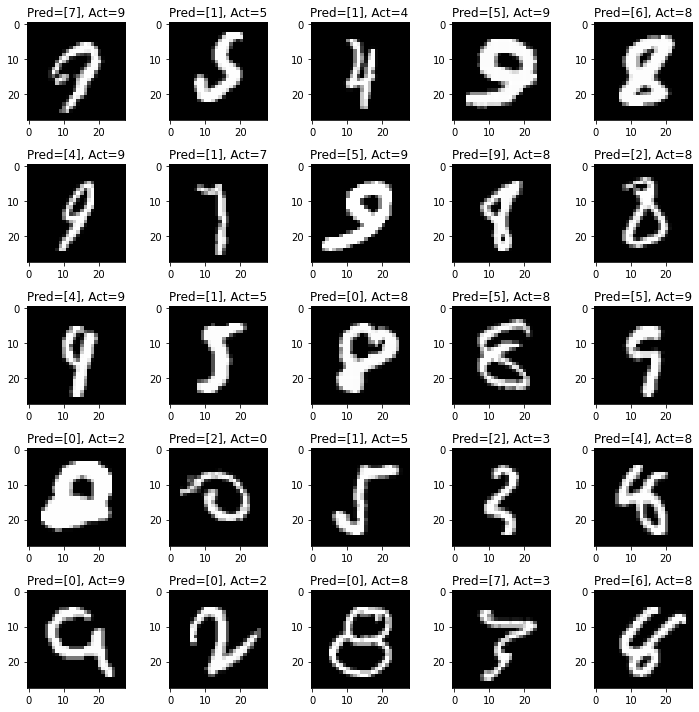

In [50]:
plot_misclassified(matrix_data, "BN")

## Without L1/L2 with GBN

In [51]:
run_model("**** Without L1/L2 with GBN ****", "GBN", True, 0, 0, cal_misclassified = True)

  0%|          | 0/469 [00:00<?, ?it/s]

**** Without L1/L2 with GBN ****
EPOCH: 1


Loss=0.23554664850234985 Batch_id=468 Accuracy=80.48: 100%|██████████| 469/469 [00:13<00:00, 34.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1226, Accuracy: 9692/10000 (96.92%)

EPOCH: 2


Loss=0.08510039001703262 Batch_id=468 Accuracy=97.10: 100%|██████████| 469/469 [00:13<00:00, 34.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0534, Accuracy: 9851/10000 (98.51%)

EPOCH: 3


Loss=0.06759607046842575 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:13<00:00, 34.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0477, Accuracy: 9862/10000 (98.62%)

EPOCH: 4


Loss=0.11330186575651169 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:13<00:00, 34.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0335, Accuracy: 9908/10000 (99.08%)

EPOCH: 5


Loss=0.07294543832540512 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:13<00:00, 35.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0419, Accuracy: 9874/10000 (98.74%)

EPOCH: 6


Loss=0.1730804443359375 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:13<00:00, 34.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0348, Accuracy: 9894/10000 (98.94%)

EPOCH: 7


Loss=0.026566291227936745 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:13<00:00, 34.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9899/10000 (98.99%)

EPOCH: 8


Loss=0.04132220149040222 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:13<00:00, 35.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9905/10000 (99.05%)

EPOCH: 9


Loss=0.05856608226895332 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:13<00:00, 35.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9908/10000 (99.08%)

EPOCH: 10


Loss=0.046718090772628784 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:13<00:00, 35.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9922/10000 (99.22%)

EPOCH: 11


Loss=0.042842403054237366 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:13<00:00, 35.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9923/10000 (99.23%)

EPOCH: 12


Loss=0.017796248197555542 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:13<00:00, 35.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9930/10000 (99.30%)

EPOCH: 13


Loss=0.1554165929555893 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:13<00:00, 35.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9918/10000 (99.18%)

EPOCH: 14


Loss=0.11189689487218857 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:13<00:00, 35.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9931/10000 (99.31%)

EPOCH: 15


Loss=0.05434045195579529 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:13<00:00, 35.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9928/10000 (99.28%)

EPOCH: 16


Loss=0.05282823368906975 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:13<00:00, 35.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9922/10000 (99.22%)

EPOCH: 17


Loss=0.01846938766539097 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:13<00:00, 35.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9932/10000 (99.32%)

EPOCH: 18


Loss=0.014051397331058979 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:13<00:00, 35.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9925/10000 (99.25%)

EPOCH: 19


Loss=0.03223445639014244 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:13<00:00, 34.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9928/10000 (99.28%)

EPOCH: 20


Loss=0.08834407478570938 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:13<00:00, 34.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9924/10000 (99.24%)

EPOCH: 21


Loss=0.017697656527161598 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:13<00:00, 35.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9940/10000 (99.40%)

EPOCH: 22


Loss=0.008779396302998066 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:13<00:00, 35.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9935/10000 (99.35%)

EPOCH: 23


Loss=0.032956961542367935 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:13<00:00, 35.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9934/10000 (99.34%)

EPOCH: 24


Loss=0.0043268403969705105 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:13<00:00, 35.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9931/10000 (99.31%)

EPOCH: 25


Loss=0.023777181282639503 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:13<00:00, 34.96it/s]



Test set: Average loss: 0.0195, Accuracy: 9937/10000 (99.37%)



### plotting first 25 misclassified images for "Without L1L2 with GBN"

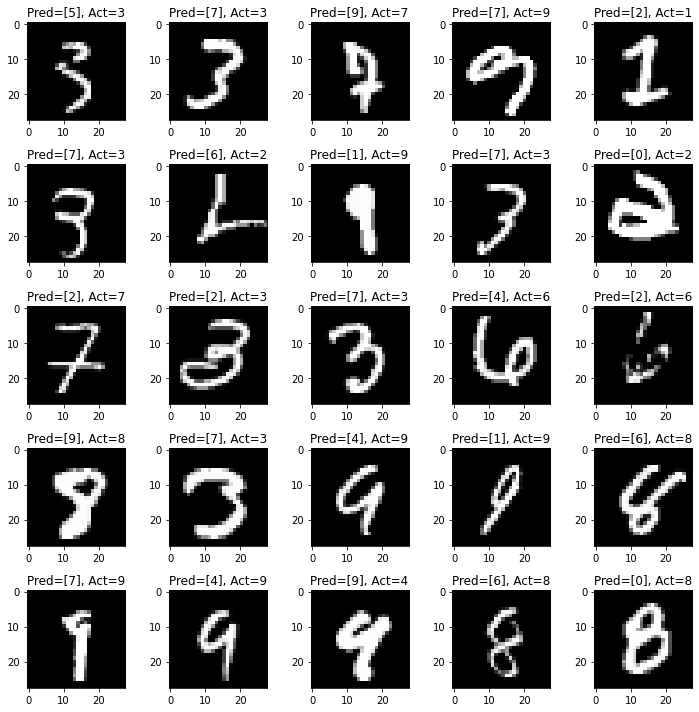

In [52]:
plot_misclassified(matrix_data, "GBN")

## With L1 with BN

In [37]:
run_model("**** With L1 with BN ****", "L1BN", False, 0.00005, 0)

  0%|          | 0/469 [00:00<?, ?it/s]

**** With L1 with BN ****
EPOCH: 1


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.36778295040130615 Batch_id=468 Accuracy=81.42: 100%|██████████| 469/469 [00:15<00:00, 29.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1240, Accuracy: 9699/10000 (96.99%)

EPOCH: 2


Loss=0.302035927772522 Batch_id=468 Accuracy=97.26: 100%|██████████| 469/469 [00:15<00:00, 29.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0789, Accuracy: 9757/10000 (97.57%)

EPOCH: 3


Loss=0.2320132553577423 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:15<00:00, 29.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0611, Accuracy: 9825/10000 (98.25%)

EPOCH: 4


Loss=0.24421778321266174 Batch_id=468 Accuracy=97.79: 100%|██████████| 469/469 [00:15<00:00, 29.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0712, Accuracy: 9791/10000 (97.91%)

EPOCH: 5


Loss=0.2569024860858917 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:15<00:00, 29.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0479, Accuracy: 9862/10000 (98.62%)

EPOCH: 6


Loss=0.30838295817375183 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:15<00:00, 29.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0517, Accuracy: 9853/10000 (98.53%)

EPOCH: 7


Loss=0.274710088968277 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:15<00:00, 29.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1571, Accuracy: 9510/10000 (95.10%)

EPOCH: 8


Loss=0.26298195123672485 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:16<00:00, 28.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0638, Accuracy: 9800/10000 (98.00%)

EPOCH: 9


Loss=0.22932957112789154 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:15<00:00, 29.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0634, Accuracy: 9815/10000 (98.15%)

EPOCH: 10


Loss=0.2161439061164856 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:15<00:00, 29.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0405, Accuracy: 9881/10000 (98.81%)

EPOCH: 11


Loss=0.17147111892700195 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:15<00:00, 29.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0657, Accuracy: 9799/10000 (97.99%)

EPOCH: 12


Loss=0.20905813574790955 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:15<00:00, 29.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0375, Accuracy: 9888/10000 (98.88%)

EPOCH: 13


Loss=0.22208815813064575 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:15<00:00, 29.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0456, Accuracy: 9863/10000 (98.63%)

EPOCH: 14


Loss=0.18489937484264374 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:15<00:00, 29.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0746, Accuracy: 9762/10000 (97.62%)

EPOCH: 15


Loss=0.24071979522705078 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:15<00:00, 29.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0609, Accuracy: 9814/10000 (98.14%)

EPOCH: 16


Loss=0.20618243515491486 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:15<00:00, 29.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0495, Accuracy: 9851/10000 (98.51%)

EPOCH: 17


Loss=0.21262052655220032 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:15<00:00, 29.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0595, Accuracy: 9813/10000 (98.13%)

EPOCH: 18


Loss=0.18921270966529846 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:16<00:00, 29.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0414, Accuracy: 9869/10000 (98.69%)

EPOCH: 19


Loss=0.1901075690984726 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:15<00:00, 30.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0569, Accuracy: 9821/10000 (98.21%)

EPOCH: 20


Loss=0.1785038411617279 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:15<00:00, 30.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0335, Accuracy: 9906/10000 (99.06%)

EPOCH: 21


Loss=0.17355716228485107 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:15<00:00, 30.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0691, Accuracy: 9790/10000 (97.90%)

EPOCH: 22


Loss=0.1860133707523346 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:15<00:00, 30.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0502, Accuracy: 9849/10000 (98.49%)

EPOCH: 23


Loss=0.1654891073703766 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:15<00:00, 30.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0432, Accuracy: 9865/10000 (98.65%)

EPOCH: 24


Loss=0.1531798392534256 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:15<00:00, 30.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0692, Accuracy: 9776/10000 (97.76%)

EPOCH: 25


Loss=0.15389800071716309 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:15<00:00, 30.75it/s]



Test set: Average loss: 0.0570, Accuracy: 9824/10000 (98.24%)



## With L1 with GBN

In [38]:
run_model("**** With L1 with GBN ****", "L1GBN", True, 0.00005, 0)

  0%|          | 0/469 [00:00<?, ?it/s]

**** With L1 with GBN ****
EPOCH: 1


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.3828755021095276 Batch_id=468 Accuracy=81.58: 100%|██████████| 469/469 [00:15<00:00, 30.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1303, Accuracy: 9657/10000 (96.57%)

EPOCH: 2


Loss=0.3118774890899658 Batch_id=468 Accuracy=97.23: 100%|██████████| 469/469 [00:15<00:00, 30.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0951, Accuracy: 9750/10000 (97.50%)

EPOCH: 3


Loss=0.2921430468559265 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:15<00:00, 30.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0631, Accuracy: 9806/10000 (98.06%)

EPOCH: 4


Loss=0.3290199935436249 Batch_id=468 Accuracy=97.76: 100%|██████████| 469/469 [00:15<00:00, 29.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0612, Accuracy: 9828/10000 (98.28%)

EPOCH: 5


Loss=0.23670265078544617 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:15<00:00, 30.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0439, Accuracy: 9872/10000 (98.72%)

EPOCH: 6


Loss=0.3009643256664276 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:15<00:00, 30.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0468, Accuracy: 9865/10000 (98.65%)

EPOCH: 7


Loss=0.20658284425735474 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:15<00:00, 30.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0451, Accuracy: 9867/10000 (98.67%)

EPOCH: 8


Loss=0.19467176496982574 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:15<00:00, 30.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0549, Accuracy: 9830/10000 (98.30%)

EPOCH: 9


Loss=0.2688960134983063 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:15<00:00, 30.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0690, Accuracy: 9784/10000 (97.84%)

EPOCH: 10


Loss=0.20343567430973053 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:15<00:00, 30.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0473, Accuracy: 9861/10000 (98.61%)

EPOCH: 11


Loss=0.21329191327095032 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:15<00:00, 30.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0629, Accuracy: 9803/10000 (98.03%)

EPOCH: 12


Loss=0.19753828644752502 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:15<00:00, 30.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0507, Accuracy: 9844/10000 (98.44%)

EPOCH: 13


Loss=0.23452576994895935 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:15<00:00, 30.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0457, Accuracy: 9844/10000 (98.44%)

EPOCH: 14


Loss=0.15913859009742737 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:15<00:00, 29.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0641, Accuracy: 9796/10000 (97.96%)

EPOCH: 15


Loss=0.2289462387561798 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:15<00:00, 30.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0372, Accuracy: 9890/10000 (98.90%)

EPOCH: 16


Loss=0.18920017778873444 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:15<00:00, 29.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0356, Accuracy: 9885/10000 (98.85%)

EPOCH: 17


Loss=0.20423512160778046 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:15<00:00, 30.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0464, Accuracy: 9854/10000 (98.54%)

EPOCH: 18


Loss=0.1894732415676117 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:15<00:00, 29.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0552, Accuracy: 9813/10000 (98.13%)

EPOCH: 19


Loss=0.1986425668001175 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:15<00:00, 30.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0449, Accuracy: 9852/10000 (98.52%)

EPOCH: 20


Loss=0.22781041264533997 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:15<00:00, 30.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0525, Accuracy: 9832/10000 (98.32%)

EPOCH: 21


Loss=0.20145021378993988 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:15<00:00, 30.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0415, Accuracy: 9875/10000 (98.75%)

EPOCH: 22


Loss=0.19096659123897552 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:14<00:00, 31.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0436, Accuracy: 9865/10000 (98.65%)

EPOCH: 23


Loss=0.17967987060546875 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:15<00:00, 30.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0347, Accuracy: 9897/10000 (98.97%)

EPOCH: 24


Loss=0.18162119388580322 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:15<00:00, 29.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0683, Accuracy: 9788/10000 (97.88%)

EPOCH: 25


Loss=0.18468885123729706 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:15<00:00, 29.61it/s]



Test set: Average loss: 0.0428, Accuracy: 9873/10000 (98.73%)



## With L2 with BN

In [39]:
run_model("**** With L2 with BN ****", "L2BN", False, 0, 0.0003)

  0%|          | 0/469 [00:00<?, ?it/s]

**** With L2 with BN ****
EPOCH: 1


Loss=0.18010014295578003 Batch_id=468 Accuracy=80.47: 100%|██████████| 469/469 [00:13<00:00, 33.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1083, Accuracy: 9723/10000 (97.23%)

EPOCH: 2


Loss=0.051545705646276474 Batch_id=468 Accuracy=97.11: 100%|██████████| 469/469 [00:13<00:00, 33.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0617, Accuracy: 9823/10000 (98.23%)

EPOCH: 3


Loss=0.018326841294765472 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:14<00:00, 33.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0502, Accuracy: 9852/10000 (98.52%)

EPOCH: 4


Loss=0.04893334582448006 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:13<00:00, 33.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0379, Accuracy: 9890/10000 (98.90%)

EPOCH: 5


Loss=0.025764748454093933 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:13<00:00, 34.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0329, Accuracy: 9902/10000 (99.02%)

EPOCH: 6


Loss=0.0686773955821991 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:13<00:00, 34.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0328, Accuracy: 9899/10000 (98.99%)

EPOCH: 7


Loss=0.04129192605614662 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:13<00:00, 34.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 9900/10000 (99.00%)

EPOCH: 8


Loss=0.03787213936448097 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:13<00:00, 33.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9916/10000 (99.16%)

EPOCH: 9


Loss=0.06918535381555557 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:13<00:00, 33.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9910/10000 (99.10%)

EPOCH: 10


Loss=0.03885653614997864 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:14<00:00, 33.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9915/10000 (99.15%)

EPOCH: 11


Loss=0.08251998573541641 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:14<00:00, 32.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9917/10000 (99.17%)

EPOCH: 12


Loss=0.06744804233312607 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:13<00:00, 33.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9910/10000 (99.10%)

EPOCH: 13


Loss=0.09417277574539185 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:13<00:00, 34.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9916/10000 (99.16%)

EPOCH: 14


Loss=0.05744348466396332 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:13<00:00, 34.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9924/10000 (99.24%)

EPOCH: 15


Loss=0.02633882500231266 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:13<00:00, 33.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9927/10000 (99.27%)

EPOCH: 16


Loss=0.048254791647195816 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:13<00:00, 34.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9915/10000 (99.15%)

EPOCH: 17


Loss=0.039235640317201614 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:13<00:00, 34.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9934/10000 (99.34%)

EPOCH: 18


Loss=0.052103374153375626 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:13<00:00, 33.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9915/10000 (99.15%)

EPOCH: 19


Loss=0.04499043524265289 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:13<00:00, 34.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9930/10000 (99.30%)

EPOCH: 20


Loss=0.006094018463045359 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:13<00:00, 34.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9932/10000 (99.32%)

EPOCH: 21


Loss=0.015073624439537525 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:13<00:00, 34.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9911/10000 (99.11%)

EPOCH: 22


Loss=0.022047316655516624 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:13<00:00, 33.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9945/10000 (99.45%)

EPOCH: 23


Loss=0.0705680325627327 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:13<00:00, 34.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9926/10000 (99.26%)

EPOCH: 24


Loss=0.0354873351752758 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:13<00:00, 35.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9945/10000 (99.45%)

EPOCH: 25


Loss=0.0360255129635334 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:13<00:00, 35.54it/s]



Test set: Average loss: 0.0222, Accuracy: 9933/10000 (99.33%)



## With L2 with GBN

In [40]:
run_model("**** With L2 with GBN ****", "L2GBN", True, 0, 0.0003)

  0%|          | 0/469 [00:00<?, ?it/s]

**** With L2 with GBN ****
EPOCH: 1


Loss=0.2143307328224182 Batch_id=468 Accuracy=81.79: 100%|██████████| 469/469 [00:13<00:00, 34.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1617, Accuracy: 9540/10000 (95.40%)

EPOCH: 2


Loss=0.0664791390299797 Batch_id=468 Accuracy=96.94: 100%|██████████| 469/469 [00:13<00:00, 35.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0749, Accuracy: 9781/10000 (97.81%)

EPOCH: 3


Loss=0.08450710773468018 Batch_id=468 Accuracy=97.74: 100%|██████████| 469/469 [00:13<00:00, 35.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0518, Accuracy: 9854/10000 (98.54%)

EPOCH: 4


Loss=0.03287766873836517 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:13<00:00, 34.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0414, Accuracy: 9885/10000 (98.85%)

EPOCH: 5


Loss=0.07952834665775299 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:13<00:00, 35.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9905/10000 (99.05%)

EPOCH: 6


Loss=0.027059907093644142 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:13<00:00, 35.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0321, Accuracy: 9898/10000 (98.98%)

EPOCH: 7


Loss=0.043784040957689285 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:12<00:00, 36.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9921/10000 (99.21%)

EPOCH: 8


Loss=0.03095151297748089 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:12<00:00, 36.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9907/10000 (99.07%)

EPOCH: 9


Loss=0.030946508049964905 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:13<00:00, 34.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9930/10000 (99.30%)

EPOCH: 10


Loss=0.10777708142995834 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:12<00:00, 36.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9922/10000 (99.22%)

EPOCH: 11


Loss=0.024421483278274536 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:12<00:00, 36.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9933/10000 (99.33%)

EPOCH: 12


Loss=0.05445036292076111 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:12<00:00, 36.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9927/10000 (99.27%)

EPOCH: 13


Loss=0.03293416276574135 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:12<00:00, 36.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9914/10000 (99.14%)

EPOCH: 14


Loss=0.015620742924511433 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:12<00:00, 36.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9922/10000 (99.22%)

EPOCH: 15


Loss=0.03073606826364994 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:12<00:00, 37.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9921/10000 (99.21%)

EPOCH: 16


Loss=0.04528557136654854 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:12<00:00, 36.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9925/10000 (99.25%)

EPOCH: 17


Loss=0.061622899025678635 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:13<00:00, 35.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9927/10000 (99.27%)

EPOCH: 18


Loss=0.025228941813111305 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:12<00:00, 36.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9933/10000 (99.33%)

EPOCH: 19


Loss=0.049232009798288345 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:12<00:00, 36.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9916/10000 (99.16%)

EPOCH: 20


Loss=0.13380122184753418 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:12<00:00, 36.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9934/10000 (99.34%)

EPOCH: 21


Loss=0.011744961142539978 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:12<00:00, 36.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9937/10000 (99.37%)

EPOCH: 22


Loss=0.00748606538400054 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:13<00:00, 35.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9931/10000 (99.31%)

EPOCH: 23


Loss=0.08192544430494308 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:12<00:00, 36.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9926/10000 (99.26%)

EPOCH: 24


Loss=0.015648597851395607 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:13<00:00, 35.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9933/10000 (99.33%)

EPOCH: 25


Loss=0.008293122053146362 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:12<00:00, 37.01it/s]



Test set: Average loss: 0.0208, Accuracy: 9933/10000 (99.33%)



## With L1L2 with BN

In [41]:
run_model("**** With L1L2 with BN ****", "L1L2BN", False, 0.00005, 0.0003)

  0%|          | 0/469 [00:00<?, ?it/s]

**** With L1L2 with BN ****
EPOCH: 1


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.31145182251930237 Batch_id=468 Accuracy=82.23: 100%|██████████| 469/469 [00:14<00:00, 32.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1357, Accuracy: 9605/10000 (96.05%)

EPOCH: 2


Loss=0.30534130334854126 Batch_id=468 Accuracy=96.89: 100%|██████████| 469/469 [00:14<00:00, 32.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0785, Accuracy: 9811/10000 (98.11%)

EPOCH: 3


Loss=0.2618657946586609 Batch_id=468 Accuracy=97.43: 100%|██████████| 469/469 [00:14<00:00, 32.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0841, Accuracy: 9773/10000 (97.73%)

EPOCH: 4


Loss=0.24064432084560394 Batch_id=468 Accuracy=97.63: 100%|██████████| 469/469 [00:14<00:00, 33.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0539, Accuracy: 9863/10000 (98.63%)

EPOCH: 5


Loss=0.3979407250881195 Batch_id=468 Accuracy=97.62: 100%|██████████| 469/469 [00:14<00:00, 33.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0736, Accuracy: 9776/10000 (97.76%)

EPOCH: 6


Loss=0.27739816904067993 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:14<00:00, 33.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0591, Accuracy: 9828/10000 (98.28%)

EPOCH: 7


Loss=0.18428358435630798 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:14<00:00, 33.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0555, Accuracy: 9850/10000 (98.50%)

EPOCH: 8


Loss=0.2183084934949875 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:14<00:00, 31.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0544, Accuracy: 9837/10000 (98.37%)

EPOCH: 9


Loss=0.20286236703395844 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:13<00:00, 33.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0548, Accuracy: 9857/10000 (98.57%)

EPOCH: 10


Loss=0.23604251444339752 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:13<00:00, 33.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0655, Accuracy: 9796/10000 (97.96%)

EPOCH: 11


Loss=0.23727425932884216 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:13<00:00, 33.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0792, Accuracy: 9733/10000 (97.33%)

EPOCH: 12


Loss=0.21849212050437927 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:13<00:00, 33.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0547, Accuracy: 9831/10000 (98.31%)

EPOCH: 13


Loss=0.2051580846309662 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:14<00:00, 32.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0490, Accuracy: 9873/10000 (98.73%)

EPOCH: 14


Loss=0.2079712599515915 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:13<00:00, 33.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0615, Accuracy: 9810/10000 (98.10%)

EPOCH: 15


Loss=0.21252739429473877 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:14<00:00, 33.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0478, Accuracy: 9857/10000 (98.57%)

EPOCH: 16


Loss=0.17242425680160522 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:13<00:00, 33.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0640, Accuracy: 9809/10000 (98.09%)

EPOCH: 17


Loss=0.24912786483764648 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:13<00:00, 34.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0465, Accuracy: 9863/10000 (98.63%)

EPOCH: 18


Loss=0.18218690156936646 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:14<00:00, 33.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0657, Accuracy: 9786/10000 (97.86%)

EPOCH: 19


Loss=0.21933776140213013 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:14<00:00, 31.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0716, Accuracy: 9785/10000 (97.85%)

EPOCH: 20


Loss=0.20089364051818848 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:14<00:00, 31.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0614, Accuracy: 9801/10000 (98.01%)

EPOCH: 21


Loss=0.28187811374664307 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:14<00:00, 32.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0484, Accuracy: 9860/10000 (98.60%)

EPOCH: 22


Loss=0.1655772179365158 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:14<00:00, 32.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0517, Accuracy: 9837/10000 (98.37%)

EPOCH: 23


Loss=0.20710448920726776 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:14<00:00, 32.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0381, Accuracy: 9894/10000 (98.94%)

EPOCH: 24


Loss=0.3213227093219757 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:14<00:00, 32.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0468, Accuracy: 9862/10000 (98.62%)

EPOCH: 25


Loss=0.2075371891260147 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:14<00:00, 32.91it/s]



Test set: Average loss: 0.0630, Accuracy: 9810/10000 (98.10%)



## With L1L2 with GBN

In [43]:
run_model("**** With L1L2 with GBN ****", "L1L2GBN", True, 0.00005, 0.0003)

  0%|          | 0/469 [00:00<?, ?it/s]

**** With L1L2 with GBN ****
EPOCH: 1


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.40117347240448 Batch_id=468 Accuracy=82.58: 100%|██████████| 469/469 [00:14<00:00, 32.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1162, Accuracy: 9722/10000 (97.22%)

EPOCH: 2


Loss=0.24345220625400543 Batch_id=468 Accuracy=97.22: 100%|██████████| 469/469 [00:14<00:00, 32.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0671, Accuracy: 9825/10000 (98.25%)

EPOCH: 3


Loss=0.28410571813583374 Batch_id=468 Accuracy=97.59: 100%|██████████| 469/469 [00:14<00:00, 32.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0595, Accuracy: 9817/10000 (98.17%)

EPOCH: 4


Loss=0.2565462291240692 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:14<00:00, 32.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0557, Accuracy: 9843/10000 (98.43%)

EPOCH: 5


Loss=0.24181897938251495 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:14<00:00, 31.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0735, Accuracy: 9797/10000 (97.97%)

EPOCH: 6


Loss=0.20348337292671204 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:14<00:00, 32.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0572, Accuracy: 9829/10000 (98.29%)

EPOCH: 7


Loss=0.18984217941761017 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:14<00:00, 32.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0449, Accuracy: 9863/10000 (98.63%)

EPOCH: 8


Loss=0.2614428997039795 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:14<00:00, 32.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0475, Accuracy: 9866/10000 (98.66%)

EPOCH: 9


Loss=0.17306439578533173 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:14<00:00, 32.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0498, Accuracy: 9853/10000 (98.53%)

EPOCH: 10


Loss=0.19093772768974304 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:14<00:00, 32.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0659, Accuracy: 9801/10000 (98.01%)

EPOCH: 11


Loss=0.20798857510089874 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:14<00:00, 33.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0649, Accuracy: 9816/10000 (98.16%)

EPOCH: 12


Loss=0.20975984632968903 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:14<00:00, 33.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0422, Accuracy: 9875/10000 (98.75%)

EPOCH: 13


Loss=0.2446378767490387 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:14<00:00, 33.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0435, Accuracy: 9875/10000 (98.75%)

EPOCH: 14


Loss=0.3230992555618286 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:14<00:00, 32.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0487, Accuracy: 9851/10000 (98.51%)

EPOCH: 15


Loss=0.19165772199630737 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:14<00:00, 32.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0423, Accuracy: 9873/10000 (98.73%)

EPOCH: 16


Loss=0.20143690705299377 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:15<00:00, 30.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0378, Accuracy: 9893/10000 (98.93%)

EPOCH: 17


Loss=0.21248571574687958 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:14<00:00, 31.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0499, Accuracy: 9837/10000 (98.37%)

EPOCH: 18


Loss=0.20114117860794067 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:14<00:00, 31.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0719, Accuracy: 9790/10000 (97.90%)

EPOCH: 19


Loss=0.18665768206119537 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:14<00:00, 31.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0490, Accuracy: 9862/10000 (98.62%)

EPOCH: 20


Loss=0.16049495339393616 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:14<00:00, 32.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0529, Accuracy: 9832/10000 (98.32%)

EPOCH: 21


Loss=0.18628115952014923 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:14<00:00, 31.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0342, Accuracy: 9895/10000 (98.95%)

EPOCH: 22


Loss=0.1457952857017517 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:14<00:00, 31.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0552, Accuracy: 9842/10000 (98.42%)

EPOCH: 23


Loss=0.17551366984844208 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:14<00:00, 32.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0448, Accuracy: 9869/10000 (98.69%)

EPOCH: 24


Loss=0.16925117373466492 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:14<00:00, 32.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0390, Accuracy: 9895/10000 (98.95%)

EPOCH: 25


Loss=0.14661690592765808 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:14<00:00, 32.15it/s]



Test set: Average loss: 0.0469, Accuracy: 9856/10000 (98.56%)



### Plot Loss

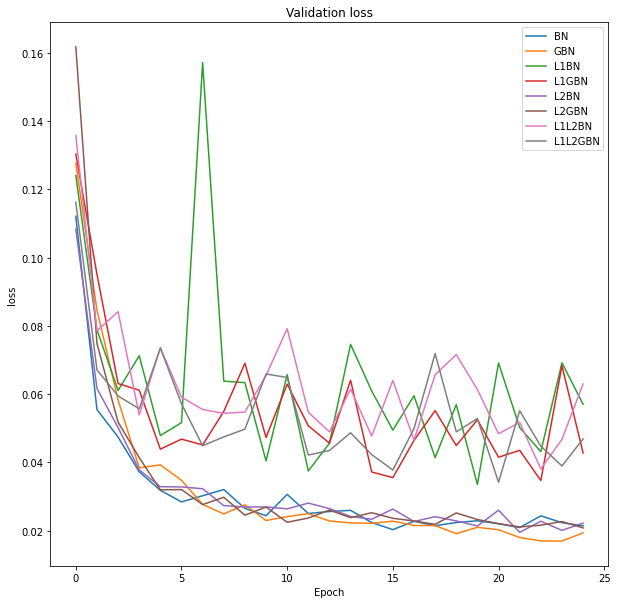

In [45]:
plot_matrix(matrix_data, "loss")

### Plot Accuracy

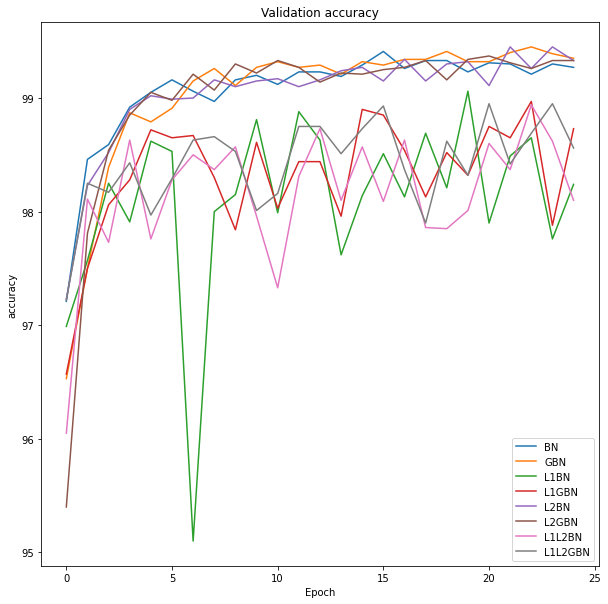

In [46]:
plot_matrix(matrix_data, "accuracy")